In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import Actions
from stable_baselines3 import PPO

In [4]:
# Load the data
data = pd.read_csv("data/AAPL.csv", parse_dates=True, index_col='Date')

# View the results
data.head()

,Close
Date,
2009-07-09,4.870000
2009-07-10,4.947143
2009-07-13,5.083571
2009-07-14,5.081071
2009-07-15,5.245714


In [7]:
# Environment setup
window_size = 10
start_index = window_size
end_index = len(data)

env = gym.make('stocks-v0', df=data, window_size=window_size, frame_bound=(start_index, end_index))
print("Observation Space:", env.observation_space)

Observation Space: Box(-10000000000.0, 10000000000.0, (10, 2), float32)


In [8]:
# Initialize variables
balance = 100000
balance_history = [balance]
shares_held = 0
action_stats = {Actions.Sell: 0, Actions.Buy: 0}
observation, info = env.reset(seed=2024)

In [9]:
# Train PPO Model
model = PPO('MlpPolicy', env, verbose=0)
model.learn(total_timesteps=10000)

In [10]:
# Model Inference and Trading Loop
step = 0
while True:
    action, _states = model.predict(observation)
    current_price = env.unwrapped.prices[env.unwrapped._current_tick]
    
    observation, reward, terminated, truncated, info = env.step(action)
    
    trade_amount = balance * 0.10
    
    if action == Actions.Buy.value:
        shares_to_buy = trade_amount / current_price
        shares_held += shares_to_buy
        balance -= trade_amount
        print(f"{step}: BUY  {shares_to_buy:.2f} shares at ${current_price:.2f} | Balance: ${balance:.2f}")
    elif action == Actions.Sell.value and shares_held > 0:
        balance += shares_held * current_price
        print(f"{step}: SELL {shares_held:.2f} shares at ${current_price:.2f} | Balance: ${balance:.2f}")
        shares_held = 0
    else:
        print(f"{step}: HOLD | Current price: ${current_price:.2f} | Balance: ${balance:.2f}")
    
    action_stats[Actions(action)] += 1
    balance_history.append(balance)
    
    step += 1
    if terminated or truncated:
        break

# Final Sell
if shares_held > 0:
    balance += shares_held * current_price
    print(f"\nFinal SELL {shares_held:.2f} shares at ${current_price:.2f} | Balance: ${balance:.2f}")
    shares_held = 0

env.close()
print("Action stats:", action_stats)
print(f"Final Balance: ${balance:.2f}")


0: BUY  134.43 shares at $74.39 | Balance: $90000.00
1: BUY  119.75 shares at $75.16 | Balance: $81000.00
2: BUY  106.67 shares at $75.93 | Balance: $72900.00
3: SELL 360.85 shares at $77.53 | Balance: $100877.25
4: BUY  128.09 shares at $78.75 | Balance: $90789.52
5: SELL 128.09 shares at $77.85 | Balance: $100761.96
6: BUY  131.01 shares at $76.91 | Balance: $90685.77
7: SELL 131.01 shares at $77.39 | Balance: $100823.87
8: HOLD | Current price: $76.93 | Balance: $100823.87
9: BUY  128.05 shares at $78.74 | Balance: $90741.48
10: SELL 128.05 shares at $78.29 | Balance: $100765.61
11: BUY  126.26 shares at $79.81 | Balance: $90689.05
12: BUY  114.49 shares at $79.21 | Balance: $81620.14
13: SELL 240.75 shares at $79.72 | Balance: $100813.27
14: HOLD | Current price: $79.18 | Balance: $100813.27
15: BUY  126.77 shares at $79.53 | Balance: $90731.94
16: BUY  114.04 shares at $79.56 | Balance: $81658.74
17: SELL 240.80 shares at $79.49 | Balance: $100799.04
18: BUY  125.27 shares at $80.

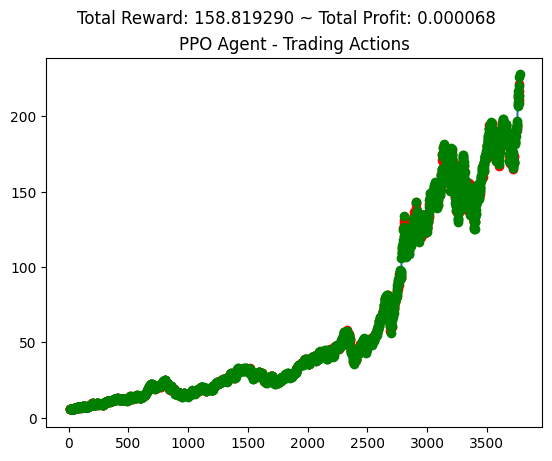

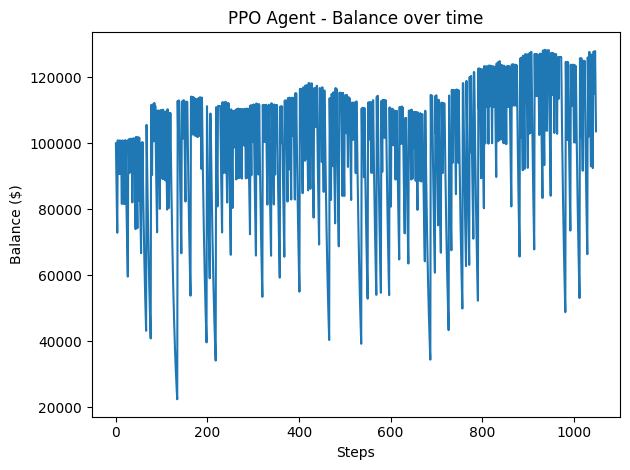

In [11]:
# Visualizations
fig, ax = plt.subplots()
env.unwrapped.render_all()
ax.set_title("PPO Agent - Trading Actions")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(balance_history)
ax2.set_title("PPO Agent - Balance over time")
ax2.set_xlabel("Steps")
ax2.set_ylabel("Balance ($)")
fig2.tight_layout()
plt.show()
